## Imports

We are using the following liberaies, most of them is commen but here are links to installations guids for the more rare ones:

Basemap: https://pypi.org/project/basemap/

AdjustText: https://pypi.org/project/adjustText/


In [145]:
import networkx as nx
import matplotlib.pyplot as plt
import json
import pickle
import numpy as np
from tqdm import tqdm
import random
import leidenalg
import igraph as ig
import seaborn as sns
import pandas as pd
from mpl_toolkits.basemap import Basemap
from adjustText import adjust_text
from matplotlib.colors import LinearSegmentedColormap
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
from collections import defaultdict
import matplotlib.patches as mpatches
from gcmap import GCMapper, Gradient
from fuzzywuzzy import process
from scipy.stats import pearsonr

## Creation of graphs

Here we create the graphs, one for the initial investigation and one for the recommendation investigation.

In [146]:
#Load the IATA data
with open('data/IATA.json') as f:
    IATA = json.load(f)
    
#Load the graph network for main analysis
with open('data/graphnetwork.gpickle', 'rb') as f:
    G = pickle.load(f)

#Load the graphnetwork_review.gpickle
with open('data/graphnetwork_reviews.gpickle', 'rb') as f:
    G_review = pickle.load(f)


## Initial Analysis
The first thing we do to get a crip of the network are to look at the degree distribution, average, median, mode, minimum, maximum degree of the nodes, connectedness, isolated nodes. This will provide us with the basic insids of the project. 

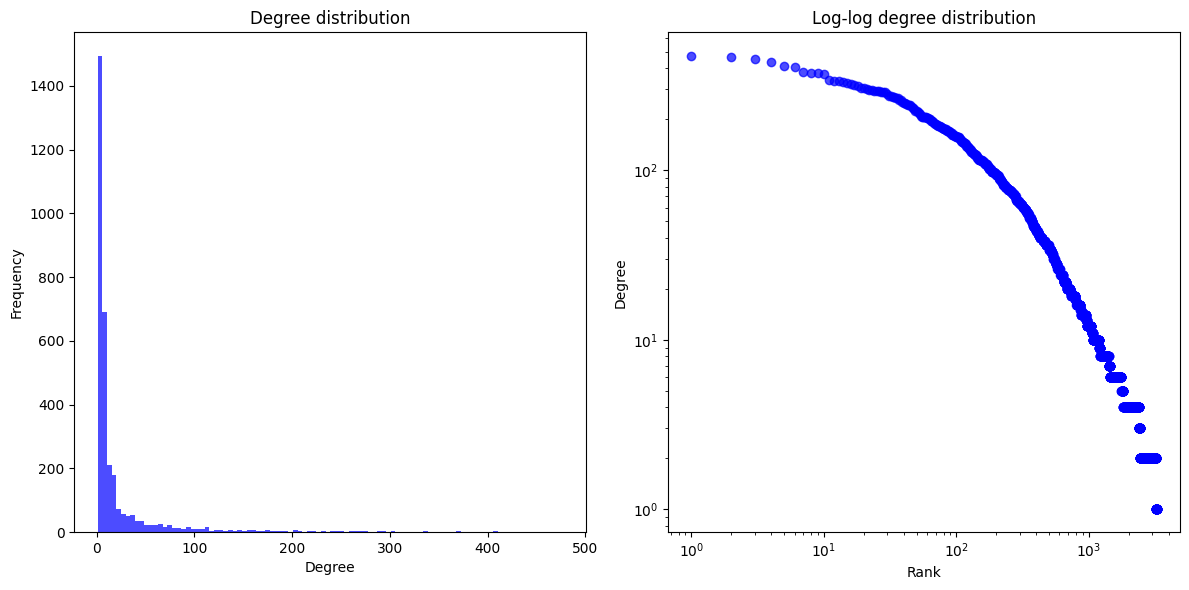

Average degree: 22.75061425061425
Median degree: 6.0
Mode degree: 2
Minimum degree: 1
Maximum degree: 477
Is the graph connected: False
Number of strongly connected components: 48
Number of weakly connected components: 7
Average clustering coefficient: 0.47450043644877865
Network density: 0.0034947180108470433
In supercitical regime: True 0.0069894360216940865


In [147]:
#Degree distribution of the network
degrees = [d for n, d in G.degree()]
#Degree distribution as histogram and log-log scatter plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(degrees, bins=100, color='blue', alpha=0.7)
ax[0].set_xlabel('Degree')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Degree distribution')
ax[1].loglog(sorted(degrees, reverse=True), 'o', color='blue', alpha=0.7)
ax[1].set_xlabel('Rank')
ax[1].set_ylabel('Degree')
ax[1].set_title('Log-log degree distribution')
plt.tight_layout()
plt.show()

#Find the average, median, mode, minimum, maximum degree of the nodes
print('Average degree:', np.mean(degrees))
print('Median degree:', np.median(degrees))
print('Mode degree:', max(set(degrees), key=degrees.count))
print('Minimum degree:', min(degrees))
print('Maximum degree:', max(degrees))

#Find connectedness of the directed graph
print('Is the graph connected:', nx.is_strongly_connected(G))
print('Number of strongly connected components:', nx.number_strongly_connected_components(G))
print('Number of weakly connected components:', nx.number_weakly_connected_components(G))

#Clustering coefficient
clustering = nx.average_clustering(G)
print('Average clustering coefficient:', clustering)


#network density
density = nx.density(G)
print('Network density:', density)

#Checks which regime the graph is in
size = len(G.nodes())
num_edges = len(G.edges())
p = (2 * num_edges) / (size * (size - 1)) #Equation 3.2 in the Network Science book.
print("In supercitical regime:", p > 1 / size,p) #Formula from section 3.6 in the Network Science book.


### What can we say about this:

At first, we see a skewness of the degree distribution, this indicates that there exists a lot of airports of few well-connected airports. And that the majority have few connections. This aligns well with the spoke–hub distribution paradigm (https://en.wikipedia.org/wiki/Spoke%E2%80%93hub_distribution_paradigm) which is important in transport networks. Furthermore, due to the graph being a real-world graph a heavy tale was expected. The log-log plot further emphasizes that our graph follows a power-law distribution and the graph also says that there are few nodes (airports) with very high connectivity. These must function as major international traveling hubs, which means that they connect many airports and have an important role as a bridge between them.
When we look at the different values of the degree we see that there is a huge variation between the minimum degree and the maximum degree. This plays into our idea that there exist few major transport hubs. The graphs are not connected and do therefore have a disconnected nature, this means that there exist some airports that are connected in a cluster, but not the the rest of the network. This led us to see if we succeded in removing all isolated airports, which we have. The difference in the Average, Median, and Mode, is due to the highly influential airports that have many connections.
If we look at the average clustering coefficient, we see a moderately high value. The value indicates that there is local clustering, this could have something to do with the region it is in and the neighbors. The low density suggests that not all possible connection is used, and the network is therefore sparsely connected, but with the clustering coefficient, it means that there are clusters that are well connected.
At last, the graph is in the supercritical regime. This aligns with the general observation that real networks do fall into the supercritical regime and have passed the critical point.


The formula for p-value: $$p = \frac{2 \cdot|L|}{N \cdot (N - 1)}$$




## _________________________________________________________________________________________
## Investigate the centrality

The next step is to look at the centrality measures: Closness, Eigenvector and betweenness centrality. This will tell us how well the airports are connected, and if the degree has an influence on it.

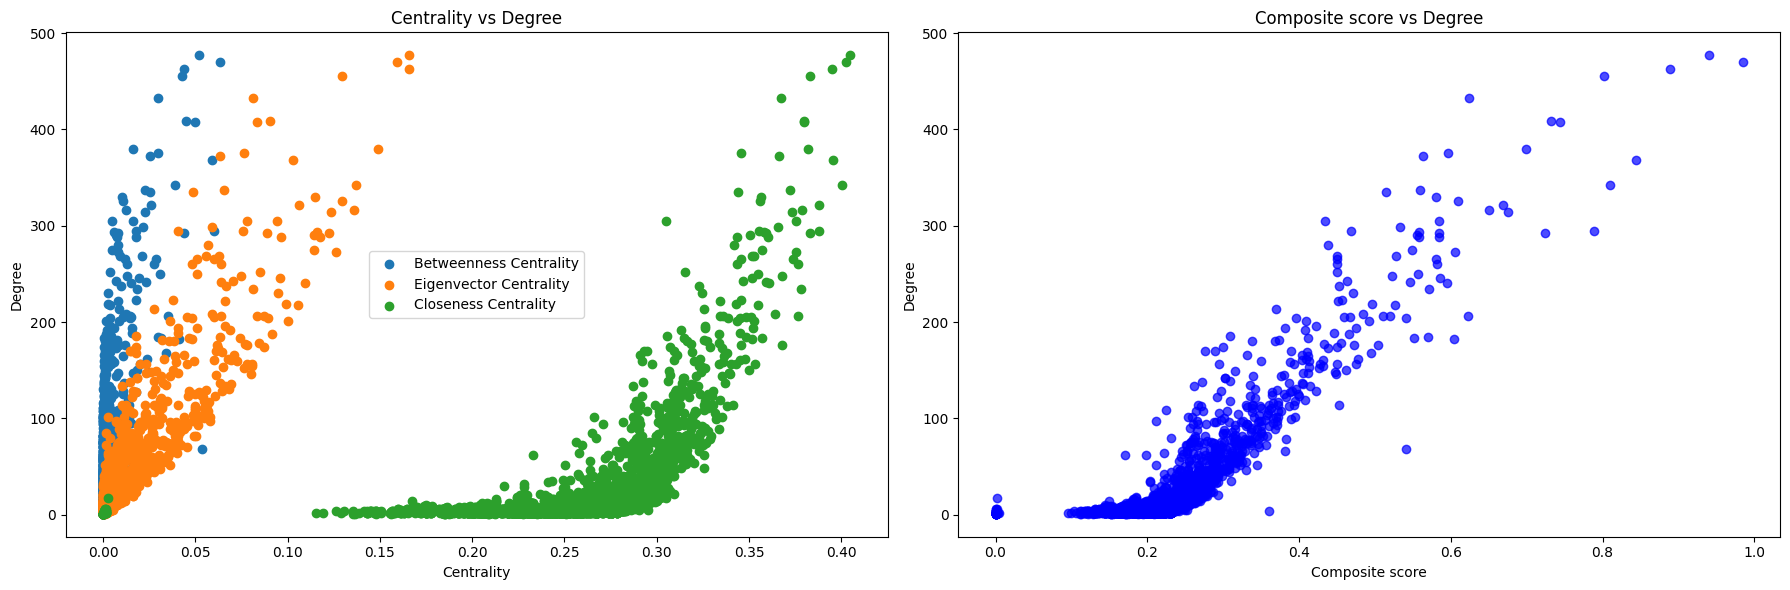

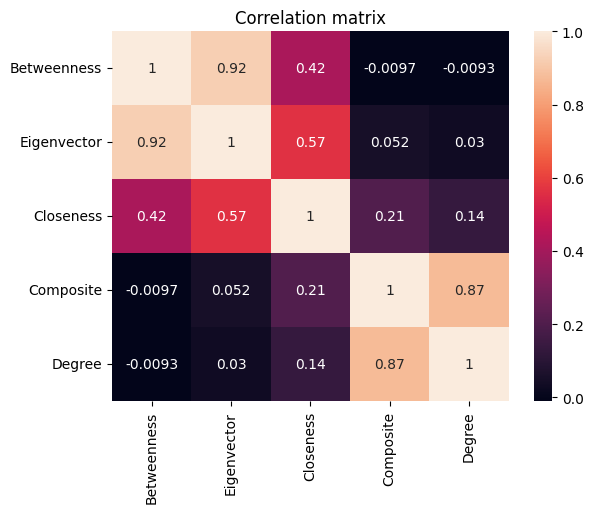

In [148]:
#Find the centrality of the graph and sort them
closeness_centrality = nx.closeness_centrality(G)
sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
eigenvevtor_centrality = nx.eigenvector_centrality(G)
sorted_eigenvevtor_centrality = sorted(eigenvevtor_centrality.items(), key=lambda x: x[1], reverse=True)
betweenness_centrality = nx.betweenness_centrality(G)
sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

# Normalizing centrality values
max_closeness = max(closeness_centrality.values())
max_eigenvector = max(eigenvevtor_centrality.values())
max_betweenness = max(betweenness_centrality.values())

airport_composite_score = {}
for node in G.nodes:
    normalized_closeness = closeness_centrality[node] / max_closeness
    normalized_eigenvector = eigenvevtor_centrality[node] / max_eigenvector
    normalized_betweenness = betweenness_centrality[node] / max_betweenness
    
    #Calculating composite score with equal weighting
    composite_score = (normalized_closeness + normalized_eigenvector + normalized_betweenness) / 3
    airport_composite_score[G.nodes[node]['name']] = composite_score

#Sorting airports by composite score
sorted_composite_score = sorted(airport_composite_score.items(), key=lambda x: x[1], reverse=True)

#A scatter plot for centrality measurements vs degree besids the composite score against degree
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
axs[0].scatter([v for k, v in sorted_betweenness_centrality], [G.degree(k) for k, v in sorted_betweenness_centrality], label='Betweenness Centrality')
axs[0].scatter([v for k, v in sorted_eigenvevtor_centrality], [G.degree(k) for k, v in sorted_eigenvevtor_centrality], label='Eigenvector Centrality')
axs[0].scatter([v for k, v in sorted_closeness_centrality], [G.degree(k) for k, v in sorted_closeness_centrality], label='Closeness Centrality')
axs[0].set_xlabel('Centrality')
axs[0].set_ylabel('Degree')
axs[0].set_title('Centrality vs Degree')
axs[0].legend()
axs[1].scatter([airport_composite_score[G.nodes[n]['name']] for n in G.nodes()], [d for n, d in G.degree()], color='blue', alpha=0.7)
axs[1].set_xlabel('Composite score')
axs[1].set_ylabel('Degree')
axs[1].set_title('Composite score vs Degree')
plt.tight_layout()
plt.show()


#Find correlation between centrality measurements, composite score and degree
df = pd.DataFrame({'Betweenness': [v for k, v in sorted_betweenness_centrality],
                   'Eigenvector': [v for k, v in sorted_eigenvevtor_centrality],
                   'Closeness': [v for k, v in sorted_closeness_centrality],
                   'Composite': [airport_composite_score[G.nodes[n]['name']] for n in G.nodes()],
                   'Degree': [d for n, d in G.degree()]})
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.title('Correlation matrix')
plt.show()


### What can we say about this:

Composit formula: $$Composite\space centrality=\frac{1}{3} \cdot (\frac{CC(n)}{max(CC(n))|n\in G}+\frac{EC(n)}{max(EC(n)|n\in G)}+\frac{BC(n)}{max(BC(n))|n\in G})$$
CC = CLoseness Centrality, EC = Eigenvecotr centrality, BC = Betweeness centrality

On the scatter plot the closeness centrality is somehow positively correlated with the degree. The closeness centrality says something about how fast information spreads in the graph and depends on how many connections the airport has. The positive correlation means that airports with more connections tend to be more central and therefore are a critical point for efficiency of transport.
The eigenvector centrality seems to be quite linear and positively correlated. However, the spread of values with the airports of high degree means that even airports with less degree can influence the network due to them being connected to other major hubs.
When it comes to the betweenness centrality (https://en.wikipedia.org/wiki/Betweenness_centrality), which tells if an airport lies on paths between other airports, we do not see a clear tendency. This amplifies the tendency in eigenvector centrality because nodes with a moderate degree still have importance in the connection between different parts of the network.
To combine this result we use the composite index where every centrality is weighted equally, what we see is that there is a linear tendency between composite score and the amount of degree.

In [149]:
#Top 10 airports by composite score
print('Top 20 airports by composite score:')
for i, (airport, score) in enumerate(sorted_composite_score[:100]):
    print(f'{i + 1}. {airport} ({score:.2f})')

Top 20 airports by composite score:
1. Charles de Gaulle International Airport (0.98)
2. Frankfurt am Main Airport (0.94)
3. Amsterdam Airport Schiphol (0.89)
4. Dubai International Airport (0.84)
5. London Heathrow Airport (0.81)
6. Istanbul Airport (0.80)
7. Los Angeles International Airport (0.79)
8. Beijing Capital International Airport (0.74)
9. Chicago O'Hare International Airport (0.73)
10. Lester B. Pearson International Airport (0.72)
11. Munich Airport (0.70)
12. Adolfo Suárez Madrid–Barajas Airport (0.67)
13. John F Kennedy International Airport (0.67)
14. Leonardo da Vinci–Fiumicino Airport (0.65)
15. Hartsfield Jackson Atlanta International Airport (0.62)
16. Narita International Airport (0.62)
17. Barcelona International Airport (0.61)
18. Zürich Airport (0.61)
19. Guarulhos - Governador André Franco Montoro International Airport (0.60)
20. Domodedovo International Airport (0.60)
21. Copenhagen Kastrup Airport (0.60)
22. Stockholm-Arlanda Airport (0.59)
23. Sheremetyevo I

Here we can see the top 100 airports with the composite score, which can be a measure for how "good" an airport are.

## _________________________________________________________________________________________
## Assortativity 
Does airport connect to airports that is alike, when it comes to degree, country and continent? That's what we are answering here.

In [150]:
#We start by defining a function that will return assortativity by tribute and assortativity by degree
#We are using formula from assortativity coefficient for categorical attributes, given in lecture 6
def assortativity_by_attribute(graph, attribute : str) -> float:
    nodes_with_attribute = nx.get_node_attributes(graph, attribute)
    Attribute = list(set(nodes_with_attribute.values()))
    Attribute_matrix = defaultdict(lambda: defaultdict(int))

    for (u, v) in graph.edges():
        Attribute_u = nodes_with_attribute[u]
        Attribute_v = nodes_with_attribute[v]
        Attribute_matrix[Attribute_u][Attribute_v] += 1
        Attribute_matrix[Attribute_v][Attribute_u] += 1

    Attribute_matrix = np.array([[Attribute_matrix[Attribute_u][Attribute_v] for Attribute_v in Attribute] for Attribute_u in Attribute])
    Attribute_matrix = Attribute_matrix / Attribute_matrix.sum()

    ai = np.sum(Attribute_matrix, axis=1)
    bi = np.sum(Attribute_matrix, axis=0)
    eii = np.trace(Attribute_matrix)
    assortativity = (eii - np.dot(ai, bi))/(1 - np.dot(ai, bi))
    return assortativity

#We are using formula from assortativity coefficient for scalar values, given in lecture 6
def calculate_assortativity_by_degree(graph):
    e = graph.number_of_edges()
    sum_ku_kv = 0 
    sum_ku = 0 
    sum_kv = 0 
    sum_ku2 = 0    
    sum_kv2 = 0    

    for i, j in graph.edges():
        ku = graph.degree(i)
        kv = graph.degree(j)
        sum_ku_kv += ku * kv
        sum_ku += ku
        sum_kv += kv
        sum_ku2 += ku**2
        sum_kv2 += kv**2

    mean_ku_kv = sum_ku_kv / e
    mean_ku = sum_ku / e
    mean_kv = sum_kv / e
    mean_ku2 = sum_ku2 / e
    mean_kv2 = sum_kv2 / e
    r = (mean_ku_kv - mean_ku * mean_kv) / (
        (mean_ku2 - mean_ku**2)**0.5 * (mean_kv2 - mean_kv**2)**0.5)

    if r == 0:
        return 0
    return r


#Find the assortativity by degree of the original network
assortativity_by_degree = calculate_assortativity_by_degree(G)
print(f"The assortativity by degree of the original network is {assortativity_by_degree:.4f}")


#Find the assortativity by country of the original network
assortativity_by_country = assortativity_by_attribute(G, 'country')

print(f"The assortativity by country of the original network is {assortativity_by_country:.4f}")

#Find the assortativity by continent of the original network
assortativity_by_continent = assortativity_by_attribute(G, 'continent')
print(f"The assortativity by continent of the original network is {assortativity_by_continent:.4f}")

#assign the composite score to the nodes
for node in G.nodes:
    G.nodes[node]['composite_score'] = airport_composite_score[G.nodes[node]['name']]

composite_cor = nx.numeric_assortativity_coefficient(G, 'composite_score') 
print('The assortativity by composite_score of the original network is', composite_cor)

The assortativity by degree of the original network is -0.0185
The assortativity by country of the original network is 0.4444
The assortativity by continent of the original network is 0.8016
The assortativity by continent of the original network is 0.12060313798045803


### What can we say about this:

The formula for assortativity by attribute: $$r=\frac {\sum \limits _{\mu} e _{\mu\mu} - \sum \limits _{\mu} a _{\mu} a _{\mu}}{1-\sum \limits _{\mu} a _{\mu} a _{\mu}}$$

The formula for assortativity by degree: $$r=\frac{	\langle k_{u}k_{v} \rangle -\langle k_{u} \rangle \langle k_{v} \rangle }{\sqrt{\langle k_{u}^{2} \rangle - \langle k_{u} \rangle ^{2}}\sqrt{\langle k_{v}^{2} \rangle - \langle k_{v} \rangle ^{2}}} $$

We use the networkx's numerical assortativity measurement, duo to our attribute being scalar, which uses equation 21 from M. E. J. Newman, Mixing patterns in networks Physical Review E, 67 026126, 2003.

Which is $$r=\frac{\sum \limits _{xy}xy(e_{xy}-a_{x}b_{y})}{\sigma _{a} \sigma _{b}}$$ 

Where $$a_{x}\space and\space b_{y}$$ are a fraction of each type of end of an edge that is attached to vertices of type i. $$e_{xy}$$ is a fraction of vertexes with the connection between i and j.

The assortativity by degree tells us that there ain't a tendency for the airports to connect to airports that are alike. Although there is a little negative value that means the airport tends to connect with airports of a lower degree. In what we have seen so far this does fit well into it since the value means that major well-connected hubs are connected to airports of lower degree.  But it seems that airports in the same country seem to connect more to airports within the same nation and continents too. Why that? This could be due to economic or political reasons.

The last output does somehow answer our second question. An assortativity value of 0.12 is not much and does not show a strong tendency of well-connected airports to connect with other well-connected airports. But this is only if we count the centrality as a measurement of a good airport.

Now we would like to test it against 100 random graphs and to do this we use the edge swap function:

In [151]:
def double_edge_swap(graph, num_swaps=None):
    #Create a copy of the graph
    H = graph.copy()
    if num_swaps is None:
        num_swaps = H.number_of_edges() * 10
    edges = list(H.edges())
    n = len(edges)
    for _ in range(num_swaps):
        while True:
            #Select two edges
            i, j = random.sample(range(n), 2)
            e1 = edges[i]
            e2 = edges[j]
            #Flip the direction of e1 with a 50% chance
            if random.random() < 0.5:
                e1 = (e1[1], e1[0])
            #Avoid self-loops and multi-edges
            if e1[0] != e2[1] and e1[1] != e2[0] and not H.has_edge(e1[0], e2[1]) and not H.has_edge(e2[0], e1[1]):
                #Create new edges e1' and e2'
                e1_new = (e1[0], e2[1])
                e2_new = (e2[0], e1[1])
                break
        #Swap edges
        if H.has_edge(*e1) and H.has_edge(*e2):  # Check if the edges exist in the graph
            H.remove_edge(*e1)
            H.remove_edge(*e2)
            H.add_edge(*e1_new)
            H.add_edge(*e2_new)
            #Update
            edges[i] = e1_new
            edges[j] = e2_new
    return H

random_network = double_edge_swap(G)
assert sorted([d for n, d in G.degree()]) == sorted([d for n, d in random_network.degree()])
print("Degree of nodes in the original network and the new 'randomized' version of the network are the same.")

list_of_graphs = []
for i in tqdm(range(100)):
    random_network = double_edge_swap(G)
    list_of_graphs.append(random_network)

Degree of nodes in the original network and the new 'randomized' version of the network are the same.


100%|██████████| 100/100 [06:57<00:00,  4.17s/it]


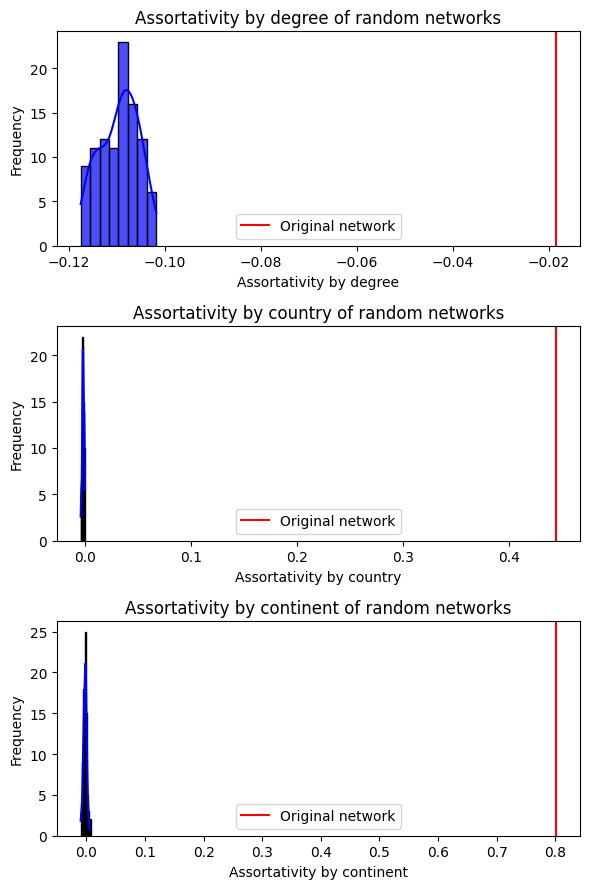

In [152]:


# Assuming assortativity calculations and list_of_graphs are defined as per your previous setup

# Calculate assortativity for random networks and the original network for degree, country, and continent
assortativity_by_degree_random = [calculate_assortativity_by_degree(graph) for graph in list_of_graphs]
assortativity_by_country_random = [assortativity_by_attribute(graph, 'country') for graph in list_of_graphs]
assortativity_by_continent_random = [assortativity_by_attribute(graph, 'continent') for graph in list_of_graphs]

# Setup a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 9))
sns.histplot(assortativity_by_degree_random, kde=True, color='blue', alpha=0.7, ax=axs[0])
axs[0].axvline(assortativity_by_degree, color='red', label='Original network')
axs[0].set_xlabel('Assortativity by degree')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Assortativity by degree of random networks')
axs[0].legend()
sns.histplot(assortativity_by_country_random, kde=True, color='blue', alpha=0.7, ax=axs[1])
axs[1].axvline(assortativity_by_country, color='red', label='Original network')
axs[1].set_xlabel('Assortativity by country')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Assortativity by country of random networks')
axs[1].legend()
sns.histplot(assortativity_by_continent_random, kde=True, color='blue', alpha=0.7, ax=axs[2])
axs[2].axvline(assortativity_by_continent, color='red', label='Original network')
axs[2].set_xlabel('Assortativity by continent')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Assortativity by continent of random networks')
axs[2].legend()

plt.tight_layout()
plt.show()


### What can we say about this:
What we can see here is that our original graph contain a structure and therefore show non-randomness and does have tendencies. 

## _________________________________________________________________________________________
## Including the BNP
We are interested in looking into the BNP per capita for the countries the airports are within and see if there is a connection between BNP per capita and countries/airports. And therefore helps answer reaches question 3.

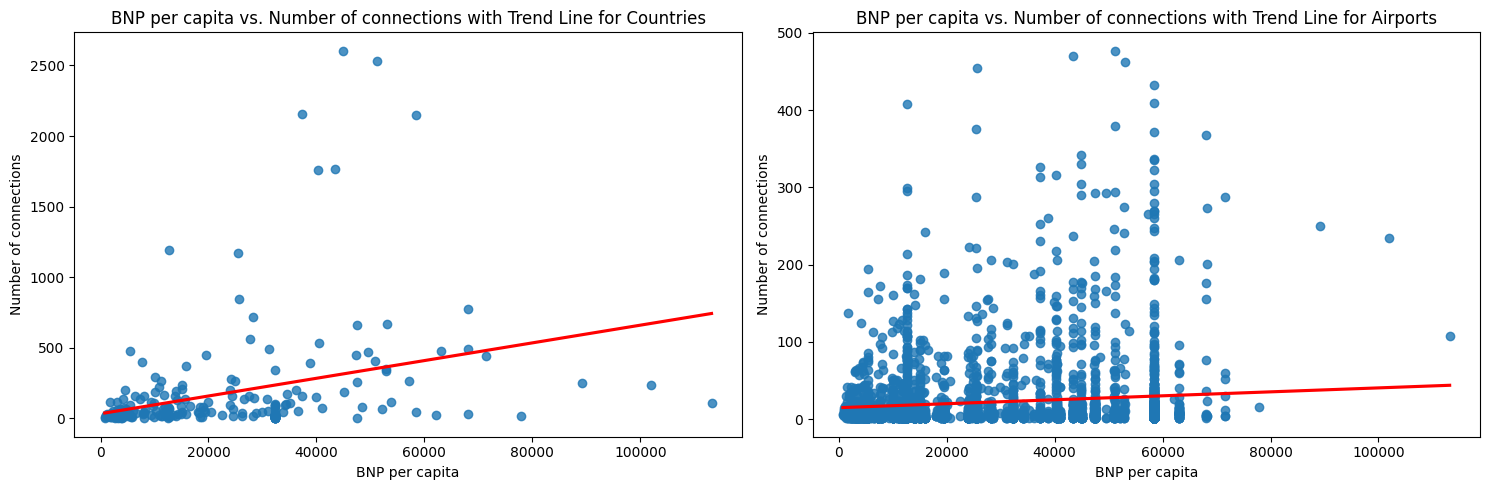

The correlation between BNP per capita and number of connections for countries is 0.3218
The correlation between BNP per capita and number of connections for airports is 0.1041


In [153]:
#Now we want to see if we can spot any patterens in BNP for countires and airports
#BNP for countries
bnp = {}
for k, v in IATA.items():
    if v['country'] not in bnp:
        bnp[v['country']] = v['BNP_per_capita']
bnp = {k: v for k, v in bnp.items() if v != 'unknown'}
connections = defaultdict(int)
for (u, v) in G.edges():
    country_u = IATA[u]['country']
    country_v = IATA[v]['country']
    if country_u != country_v:
        connections[country_u] += 1
        connections[country_v] += 1

connections = {k: v for k, v in connections.items() if k in bnp}
bnp_connections = {k: (bnp[k], v) for k, v in connections.items()}


bnp_values = [v[0] for k, v in bnp_connections.items()]
connections_values = [v[1] for k, v in bnp_connections.items()]
correlation = np.corrcoef(bnp_values, connections_values)
bnp_airports = {}
for k, v in IATA.items():
    if v['country'] in bnp:
        bnp_airports[k] = bnp[v['country']]
bnp_airports = {k: v for k, v in bnp_airports.items() if v != 'unknown'}

connections_airports = defaultdict(int)
for (u, v) in G.edges():
    if u in bnp_airports and v in bnp_airports:
        connections_airports[u] += 1
        connections_airports[v] += 1

bnp_connections_airports = {k: (bnp_airports[k], v) for k, v in connections_airports.items()}


#Find unique coutries and continents
countries = set([v['country'] for k, v in IATA.items()])
continent_to_country = {v['country']: v['continent'] for k, v in IATA.items()}

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.regplot(
    x=[v[0] for k, v in bnp_connections.items()],
    y=[v[1] for k, v in bnp_connections.items()],
    scatter=True,
    line_kws={"color": "red"},
    ci=None,
    ax=axs[0]
)
axs[0].set_xlabel('BNP per capita')
axs[0].set_ylabel('Number of connections')
axs[0].set_title('BNP per capita vs. Number of connections with Trend Line for Countries')

sns.regplot(
    x=[v[0] for k, v in bnp_connections_airports.items()],
    y=[v[1] for k, v in bnp_connections_airports.items()],
    scatter=True,
    line_kws={"color": "red"},
    ci=None,
    ax=axs[1]
)
axs[1].set_xlabel('BNP per capita')
axs[1].set_ylabel('Number of connections')
axs[1].set_title('BNP per capita vs. Number of connections with Trend Line for Airports')
plt.tight_layout()

plt.show()

#Find the correlation between BNP per capita and number of connections for countries and airports
correlation_countries = np.corrcoef(bnp_values, connections_values)
correlation_airports = np.corrcoef([v[0] for k, v in bnp_connections_airports.items()], [v[1] for k, v in bnp_connections_airports.items()])
print(f"The correlation between BNP per capita and number of connections for countries is {correlation_countries[0, 1]:.4f}")
print(f"The correlation between BNP per capita and number of connections for airports is {correlation_airports[0, 1]:.4f}")




### What can we say about this:

As we can see on these graphs, we do have a positive correlation between countries/airports and the BNP per Capita. This means that wealthier countries tend to have airports with more connections. The relationship seems to be moderately strong given the dispersion of the data points around the trend line and the correlation. However, the correlation is not that strong if we look at each airport. This could affect the result of research question 3 since we now know there is a better chance to find those good airports within wealthier nations. If we look at centrality.

## _________________________________________________________________________________________
## Communities
We do now want to look at the communities next, due to os have a strong idea that the continent does somehow splits from eachother.

In [154]:
#FUnction that finds the communities
def find_communities(graph):
    G_ig = ig.Graph(directed=True)
    G_ig.add_vertices(list(graph.nodes()))
    G_ig.add_edges(list(graph.edges()))
    partition = leidenalg.find_partition(G_ig, leidenalg.ModularityVertexPartition)
    community_dict = {str(node): partition.membership[idx] for idx, node in enumerate(graph.nodes())}
    return community_dict

community_dict = find_communities(G)
num_communities = len(set(community_dict.values()))
community_sizes = np.bincount(list(community_dict.values()))
community_sizes = community_sizes[community_sizes > 0]
print(f"Community sizes: {community_sizes}")

#This is for inside of the communities
community_continents = {}
for i in range(num_communities):
    community_nodes = [n for n, comm in community_dict.items() if comm == i]
    continent_counts = {}
    for node in community_nodes:
        if node in IATA and 'continent' in IATA[node]:
            continent = IATA[node]['continent']
            if continent in continent_counts:
                continent_counts[continent] += 1
            else:
                continent_counts[continent] = 1
    if continent_counts:
        dominant_continent = max(continent_counts, key=continent_counts.get)
        community_continents[i] = {
            'dominant_continent': dominant_continent,
            'continent_details': continent_counts
        }

print(f"Community continents: {community_continents}")


Community sizes: [638 500 492 302 295 267 218 170 131  95  47  28  22  10   9   7   6   4
   4   4   3   2   2]
Community continents: {0: {'dominant_continent': 'North America', 'continent_details': {'North America': 632, 'Oceania': 1, 'South America': 4, 'Europe': 1}}, 1: {'dominant_continent': 'Europe', 'continent_details': {'Europe': 440, 'Africa': 52, 'Asia': 8}}, 2: {'dominant_continent': 'Asia', 'continent_details': {'Oceania': 5, 'Asia': 487}}, 3: {'dominant_continent': 'South America', 'continent_details': {'South America': 300, 'North America': 2}}, 4: {'dominant_continent': 'Asia', 'continent_details': {'Africa': 25, 'Europe': 2, 'Asia': 268}}, 5: {'dominant_continent': 'Oceania', 'continent_details': {'Oceania': 265, 'South America': 1, 'Asia': 1}}, 6: {'dominant_continent': 'Africa', 'continent_details': {'Africa': 218}}, 7: {'dominant_continent': 'Europe', 'continent_details': {'Europe': 125, 'Asia': 45}}, 8: {'dominant_continent': 'North America', 'continent_details': {'N


### What can we say about this:
This shows that there exist multiple large communities, which represent major flight hubs. The small ones may represent smaller and more specialist airports, like airports in remote areas. The next thing was to gain a deeper insight into where the airports were placed. As we can see on the last output, the communities mainly are continental things, which does make sense since the assortativity by continent of the original network is 0.8016.

Documentation for leidenalg.find_partition can be found here (https://leidenalg.readthedocs.io/en/stable/reference.html).

Therefore it is interesting to look into each continent as a community and what we are doing here:


In [155]:
#Find all unique continents
continents = set([v['continent'] for k, v in IATA.items()])

#Remove Antarctica due to it not haveing valid airports
continents = [i for i in continents if i != 'Antarctica']

#Find the subgraphs for each continent
subgraphs = []
for i in continents:
    continent_airports = [k for k, v in IATA.items() if v['continent'] == i]
    continent_airports = [k for k in continent_airports if G.has_node(k)]
    subgraph = G.subgraph(continent_airports)
    subgraphs.append(subgraph)

for i, subgraph in enumerate(subgraphs):
    continent = list(continents)[i]
    print(f"Continent: {continent}, Number of airports: {subgraph.number_of_nodes()}")

#Now we want to find the basic properties of the subgraphs
subgraph_properties = []
for i, subgraph in enumerate(subgraphs):
    subgraph_properties.append({
        'Continent': list(continents)[i],
        'Number of nodes': subgraph.number_of_nodes(),
        'Number of edges': subgraph.number_of_edges(),
        'Density': nx.density(subgraph),
        'Average degree': np.mean([d for n, d in subgraph.degree()]),
        'Average clustering coefficient': nx.average_clustering(subgraph)
    })

subgraph_properties = pd.DataFrame(subgraph_properties)
print(subgraph_properties)

Continent: Oceania, Number of airports: 281
Continent: Africa, Number of airports: 299
Continent: North America, Number of airports: 943
Continent: Asia, Number of airports: 812
Continent: South America, Number of airports: 305
Continent: Europe, Number of airports: 616
       Continent  Number of nodes  Number of edges   Density  Average degree  \
0        Oceania              281             1086  0.013803        7.729537   
1         Africa              299             1369  0.015364        9.157191   
2  North America              943             8511  0.009581       18.050901   
3           Asia              812             8375  0.012718       20.628079   
4  South America              305             1423  0.015347        9.331148   
5         Europe              616            10844  0.028624       35.207792   

   Average clustering coefficient  
0                        0.503871  
1                        0.461607  
2                        0.472613  
3                       

To talk about this we have to split it up into the continents. (Antarctica is removed due to not having any valid airports)

1. Africa: Africa shows moderate connectivity and a relatively high clustering, suggesting regional networks with several direct interconnections.

2. North America: North America has a high degree and with the high clustering it means that North America has high regional connectivity.

3. South America: Have low average degree and clustering, this means that the airports may be connected in "lines".

4. Oceania: Oceania has the highest clustering, this is probably due to the geographic constraints that the continent has. Furthermore, the area doesn't have a high average degree, which means that the airports are sparsely distributed.

5. Europe: As a major transport hub Europe has a very dense network with the highest degree and pretty high clustering. This means that airports in Europe are well-connected.

6. Asia: Asia has a large network with the highest clustering coefficient, indicating a highly integrated network where many airports are directly interconnected, forming many clusters.

Amount of top airports {'Oceania': 19, 'Africa': 78, 'North America': 291, 'Asia': 293, 'South America': 30, 'Europe': 289}


C:\Users\Rasmu\AppData\Local\Temp\ipykernel_29124\1001643851.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.18432748753827335' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subgraph_properties.at[i, 'Average composite score'] = np.mean(composite_scores)
C:\Users\Rasmu\AppData\Local\Temp\ipykernel_29124\1001643851.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '30355.334740816008' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subgraph_properties.at[i, 'Average BNP per capita'] = np.mean(bnp_values)


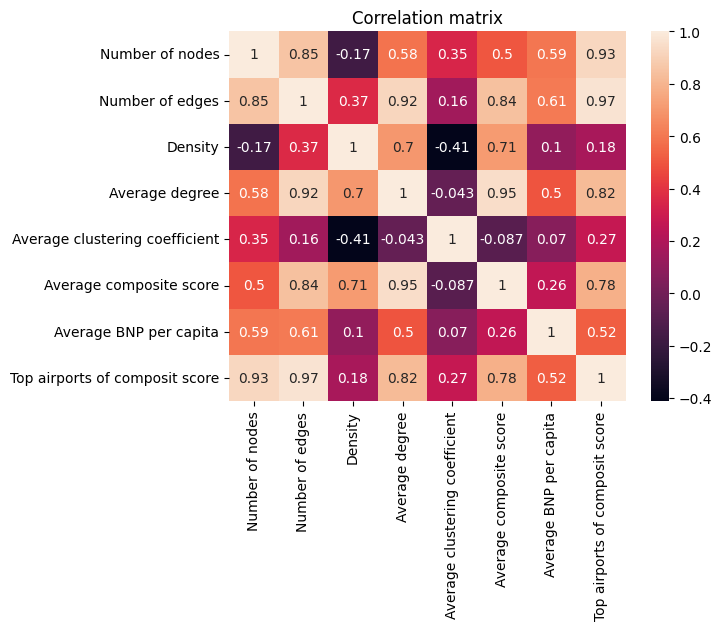

In [156]:
def get_continent_by_airport_name(airport_dict, airport_name):
    for airport_code, airport_info in airport_dict.items():
        if airport_info['name'] == airport_name:
            return airport_info['continent']
    return None

#top 100 airports by composite score
top_airports = sorted_composite_score[:1000]

list_of_continents = []
for i in range(0, 1000):
    airport_name = top_airports[i][0]
    continent = get_continent_by_airport_name(IATA, airport_name)
    list_of_continents.append(continent)

#Find amount of all continents
continent_counts = {continent: list_of_continents.count(continent) for continent in continents}
continent_counts = {k: v for k, v in continent_counts.items() if v > 0}
print("Amount of top airports",continent_counts)

#Add this as a new column to the subgraph properties with average composite score and BNP per capita
subgraph_properties['Average composite score'] = 0
subgraph_properties['Average BNP per capita'] = 0
for i, subgraph in enumerate(subgraphs):
    airports = subgraph.nodes()
    composite_scores = [airport_composite_score[G.nodes[n]['name']] for n in airports]
    bnp_values = [IATA[n]['BNP_per_capita'] for n in airports if 'BNP_per_capita' in IATA[n] and IATA[n]['BNP_per_capita'] != 'unknown']
    subgraph_properties.at[i, 'Average composite score'] = np.mean(composite_scores)
    subgraph_properties.at[i, 'Average BNP per capita'] = np.mean(bnp_values)

#Add the amount of top airports to the subgraph properties
subgraph_properties['Top airports of composit score'] = [continent_counts[continent] for continent in subgraph_properties['Continent']]
#See if there is any correlation between amount of top airports and all the other properties without continent and create a heatmap
df = subgraph_properties.drop(columns=['Continent'])
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.title('Correlation matrix')
plt.show()


### What can we say about this:

From this analysis of continents, we can say that larger and more connected airport networks tend to include more top-rated airports and also achieve higher average composite scores, which likely reflect greater overall network effectiveness and centrality. However, the specific setup of the network as density local clustering and economic status of the region also play roles in the result.

Some short notes on specific results:

1. Results like several nodes and several edges are pretty logical and therefore expected.
2. Since the top airports are ranked by composite score, it does make sense.
3. On the other hand, regions with more airports and more connections also tend to have more top airports, which may reflect larger and more complex airport networks.
4. However, a lower density indicates fewer connections relative to the number of nodes, which in turn might suggest that having a tightly connected network is not necessary for having a higher number of top airports.
5. We can see that economically richer regions tend to have more connections, which fit into the previous discoveries.
6. At last it does show a tendency between the average BNP per capita and amount of top airports.


To discuss the research questions, we can see that BNP per capita is correlated with the top airports. Furthermore, continents with a higher amount of edges do have more of the top airports.

## _________________________________________________________________________________________
## Combining reviews and airports

The reviews also are important in this project, and specific for the second reaches question. Therefore we will investigate the assortivity for average rating, BNP, and average recommendation per capita. So far we have talked about the composite value as a way of measuring how good an airport is, however, it is sometimes more giving to look at what people mean as a way of saying how good an airport is.

In [157]:
#FInd the numeric assortativity coefficient
BNP_per_capita_review = nx.numeric_assortativity_coefficient(G_review, 'BNP_per_capita')
average_recommendation_review = nx.numeric_assortativity_coefficient(G_review, 'average_recommendation')
average_recommendation_per_BNP_review = nx.numeric_assortativity_coefficient(G_review, 'average_recommendation_per_BNP')

print("Numeric assortativity coefficient for BNP_per_capita:", BNP_per_capita_review)
print("Numeric assortativity coefficient for average_recommendation:", average_recommendation_review)
print("Numeric assortativity coefficient for average_recommendation_per_BNP:", average_recommendation_per_BNP_review)


Numeric assortativity coefficient for BNP_per_capita: -0.0243539468018841
Numeric assortativity coefficient for average_recommendation: -0.014853929877629802
Numeric assortativity coefficient for average_recommendation_per_BNP: -0.0018438828689898315


### What can we say about this:
We can say that there is no tendency for airports to connect to other airports with the same level of good reviews. Therefore we can answer our second research question and say no, there is no such tendency in good airports mostly connect to other well-rated airports.

In [158]:
#See which continents and nation have the greatest average recommendation and average recommendation per BNP
average_recommendations = {}
average_recommendation_per_BNP_review = {}
for node in G_review.nodes():
    if 'average_recommendation' in G_review.nodes[node]:
        average_recommendations[node] = G_review.nodes[node]['average_recommendation']
    if 'average_recommendation_per_BNP' in G_review.nodes[node]:
        average_recommendation_per_BNP_review[node] = G_review.nodes[node]['average_recommendation_per_BNP']

average_recommendations_per_continent = defaultdict(list)
average_recommendation_per_BNP_per_continent = defaultdict(list)
for node, recommendation in average_recommendations.items():
    if node in IATA:
        continent = IATA[node]['continent']
        average_recommendations_per_continent[continent].append(recommendation)

for node, recommendation in average_recommendation_per_BNP_review.items():
    if node in IATA:
        continent = IATA[node]['continent']
        average_recommendation_per_BNP_per_continent[continent].append(recommendation)


average_recommendations_per_continent = {k: np.mean(v) for k, v in average_recommendations_per_continent.items()}
average_recommendation_per_BNP_per_continent = {k: np.mean(v) for k, v in average_recommendation_per_BNP_per_continent.items()}

#convert to pandas dataframe
average_recommendations_per_continent = pd.DataFrame(average_recommendations_per_continent.items(), columns=['Continent', 'Average recommendation'])
average_recommendation_per_BNP_per_continent = pd.DataFrame(average_recommendation_per_BNP_per_continent.items(), columns=['Continent', 'Average recommendation per BNP'])


#Make the order of the continents follow the order in subgraph_properties
average_recommendations_per_continent = average_recommendations_per_continent.set_index('Continent').reindex(subgraph_properties['Continent']).reset_index()
average_recommendation_per_BNP_per_continent = average_recommendation_per_BNP_per_continent.set_index('Continent').reindex(subgraph_properties['Continent']).reset_index()

#remove the continents from the two dataframes and add the average recommendation and average recommendation per BNP to the subgraph_properties
subgraph_properties['Average recommendation'] = average_recommendations_per_continent['Average recommendation']
subgraph_properties['Average recommendation per BNP'] = average_recommendation_per_BNP_per_continent['Average recommendation per BNP']



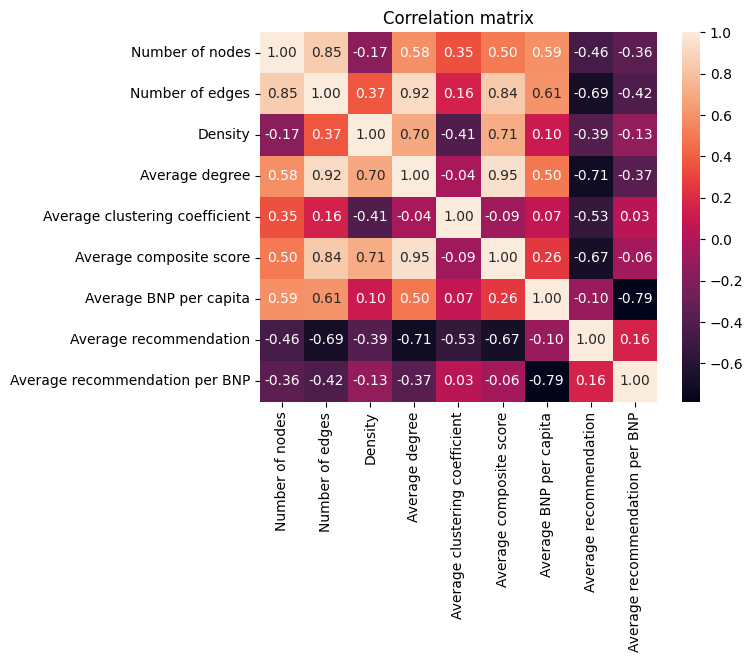

In [159]:
#Create a heatmap for the correlation matrix
df = subgraph_properties.drop(columns=['Continent','Top airports of composit score'])
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f")  # Use fmt to format the annotation
plt.title('Correlation matrix')
plt.show()



### What can we say about this:
In this case we are primarily looking at the Average recommendation and average recommendation per BNP. For both of them there seem to be a negative correlation between most of the measurments and highly connected airports does not means it have good recommendations.